In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/f_bien_Gonzalo.csv
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/vu_bien_Gonzalo.csv
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/f_8_OBS_MdP_MAR_2011_MAY_2012.csv
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/vu_8_OBS_MdP_MAR_2011_MAY_2012.csv
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/8_OBS_MdP_MAR_2011_MAY_2012.xlsx
!wget https://raw.githubusercontent.com/lupalon/Mareas2022/main/HKmh.xlsx
HKmh=pd.read_excel(r'HKmh.xlsx')
HKmh.rename(columns={HKmh.columns[0]:'nom',HKmh.columns[1]:'H',HKmh.columns[2]:'sigma',HKmh.columns[3]:'K'},inplace=True)
sigmas=HKmh.sigma.iloc[0::].values #velocidades angulares teoria de equilibrio.
fc=pd.read_csv(r'f_bien_Gonzalo.csv') #ambos dos me brindan info horaria para 2 días.
vuc=pd.read_csv(r'vu_bien_Gonzalo.csv')
F=pd.read_csv(r'f_8_OBS_MdP_MAR_2011_MAY_2012.csv') #119803
VU=pd.read_csv(r'vu_8_OBS_MdP_MAR_2011_MAY_2012.csv')
serie=pd.read_excel(r'8_OBS_MdP_MAR_2011_MAY_2012.xlsx')

--2022-12-01 03:40:21--  https://raw.githubusercontent.com/lupalon/Mareas2022/main/f_bien_Gonzalo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9738 (9.5K) [text/plain]
Saving to: ‘f_bien_Gonzalo.csv’

f_bien_Gonzalo.csv  100%[===================>]   9.51K  --.-KB/s    in 0s      

2022-12-01 03:40:21 (68.0 MB/s) - ‘f_bien_Gonzalo.csv’ saved [9738/9738]

--2022-12-01 03:40:21--  https://raw.githubusercontent.com/lupalon/Mareas2022/main/vu_bien_Gonzalo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9830 (9.6K) [text/plai

In [ ]:
serie.describe()

,OBS
count,119803.000000
mean,0.955066
std,0.437562
min,-0.528000
25%,0.646000
50%,0.925000
75%,1.244000
max,2.612000


In [ ]:
serie1=serie.OBS.values - serie.OBS.mean() #Defino el array de valores para la serie
len(F.T)

8

In [ ]:
dt=1/12
def AnAr(serie,F,VU):
  Q=len(F.T) #-> Recordar que ya no es F de sigmas, sino que de los factores nodales
  #T=len(serie1)
  s=serie1#[0:(T-1+T%2)]
  T=len(s)
  #t=np.linspace(0,len(s)*dt,len(s))
  eleA=[]
  eleB=[]
  for i in range (len(F.T)):
    eleA.append(F.iloc[:,i].values*np.cos(VU.iloc[:,i].values))
    eleB.append(F.iloc[:,i].values*np.sin(VU.iloc[:,i].values))
  eleA=np.array(eleA)
  eleB=np.array(eleB)
  ELE=np.concatenate((eleA.T,eleB.T),axis=1)
  vemosELE=np.linalg.lstsq(ELE,s,rcond=None)
  H=np.around(np.sqrt(vemosELE[0][0:Q]**2+vemosELE[0][Q::]**2),4)
  K=np.around(np.arctan2(vemosELE[0][Q::],vemosELE[0][0:Q]),4)
  K=K*180/np.pi
  K[K<0]=K[K<0]+360
  K=np.around(K,4)
  return(H,K)

In [ ]:
H,K=AnAr(serie1,F,VU)

In [ ]:
print(F.iloc[:,0])
print(K)
#pensaba que era error de escala y no.

0         1.001609
1         1.001609
2         1.001609
3         1.001610
4         1.001610
            ...   
119798    1.015544
119799    1.015544
119800    1.015545
119801    1.015545
119802    1.015545
Name: # ['M2', Length: 119803, dtype: float64
[305.9701  15.6303 265.3015  28.3328 170.3862  76.8394 163.3388 182.2857]


In [ ]:
def pred(H,K,F,VU):
    fechas_pred=pd.date_range("03-27-11 03:00:00", periods=len(F), freq= "5min") #mes-dia-año
    Q=len(H)
    ondas=pd.DataFrame()
    for i in range(Q):
        #ondas.insert(i,i,(H[i])F.iloc[:,i].values*np.cos(np.deg2rad(sigmas[i]*t1-a1[i])))
        ondas.insert(i,i,H[i]*F.iloc[:,i].values*np.cos((VU.iloc[:,i].values-np.deg2rad(K[i])))) #epoca a radianes nada mas.
    suma=ondas.sum(axis=1).values
    prediccion=pd.DataFrame(np.around(suma,4),index=fechas_pred,columns=['pred'])
    return prediccion

In [ ]:
ts=np.linspace(0,len(serie1)*dt,len(serie1))
pred7=pred(H,K,F,VU)
pred7.index.name='fechas'
pred7.reset_index(inplace=True)

In [ ]:
M2=H[0]*F.iloc[:,0].values*np.cos((VU.iloc[:,0].values-np.deg2rad(K[0]))) # de prueba

[(0.0, 400.0)]

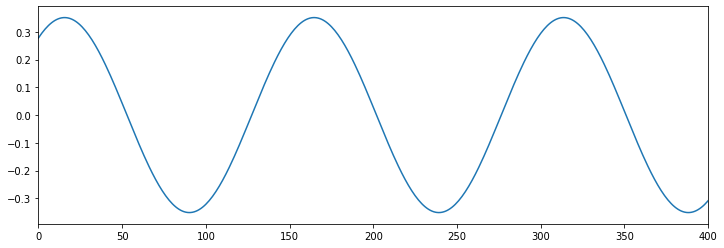

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(M2)
axs.set(xlim=[0,400])

In [ ]:
print(pred7.pred.mean())
print(pred7.pred.max())
print(pred7.pred.min())
print((serie.OBS-serie.OBS.mean()).mean())
print((serie.OBS-serie.OBS.mean()).max())
print((serie.OBS-serie.OBS.mean()).min())

-5.83574701802139e-05
0.8094
-0.7148
5.1717675315543633e-17
1.6569339499010878
-1.4830660500989123


In [ ]:
serie.iloc[28015:28396]

,FECHA,OBS
28015,2011-07-02 09:35:00,1.170
28016,2011-07-02 09:40:00,1.182
28017,2011-07-02 09:45:00,1.205
28018,2011-07-02 09:50:00,1.220
28019,2011-07-02 09:55:00,1.233
...,...,...
28391,2011-07-03 16:55:00,1.003
28392,2011-07-03 17:00:00,0.991
28393,2011-07-03 17:05:00,0.999
28394,2011-07-03 17:10:00,0.998


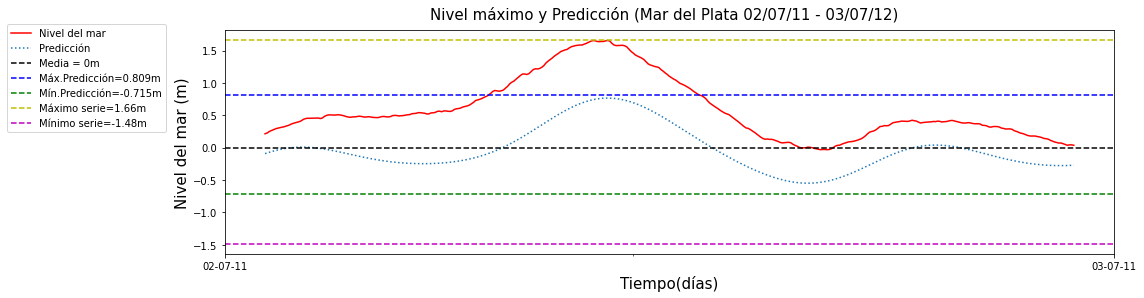

In [ ]:
import matplotlib.dates as mdates
fig,axs=plt.subplots(1,1,figsize=(16,4))
#axs.plot(serie.FECHA,serie.OBS-serie.OBS.mean())
axs.plot(serie.FECHA.iloc[28015:28396],serie.OBS.iloc[28015:28396]-serie.OBS.mean(),'r')
axs.plot(pred7.fechas.iloc[28015:28396],pred7.pred.iloc[28015:28396],':')
axs.axhline((serie.OBS-serie.OBS.mean()).mean(), color='k', ls='--')
#axs.axhline(y=-.3,color='r')
axs.axhline(pred7.pred.max(), color='b', ls='--')
axs.axhline(pred7.pred.min(), color='g', ls='--')
axs.axhline((serie.OBS-serie.OBS.mean()).max(), color='y', ls='--')
axs.axhline((serie.OBS-serie.OBS.mean()).min(), color='m', ls='--')
#axs.xaxis.set_minor_locator(mdates.HourLocator())
axs.xaxis.set_minor_locator(mdates.DayLocator())
axs.xaxis.set_major_locator(mdates.MonthLocator())
#axs.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#fig.suptitle('Serie de Nivel del Mar y Predicción (Mar del Plata 27/03/2011 - 16/05/2012)', x=0.58 ,y=1.025,fontsize=15)
fig.suptitle('Nivel máximo y Predicción (Mar del Plata 02/07/11 - 03/07/12)', x=0.58 ,y=1.025,fontsize=15)
plt.xlabel('Tiempo(días)', fontsize=15)
#plt.xlabel('Tiempo(meses)', fontsize=15)
plt.ylabel('Nivel del mar (m)', fontsize=15)
plt.legend(('Nivel del mar','Predicción','Media = 0m','Máx.Predicción=0.809m','Mín.Predicción=-0.715m','Máximo serie=1.66m','Mínimo serie=-1.48m'),bbox_to_anchor=[-.25, 1.05], loc='upper left')
plt.tight_layout()

In [ ]:
posicionMM=find_peaks(pred7.pred)[0]
posicionmm=find_peaks(-pred7.pred)[0]
altass=pred7.iloc[posicionMM]
bajass=pred7.iloc[posicionmm]
PeriodopM=np.diff(posicionMM)/12
Periodopm=np.diff(posicionmm)/12
print(np.mean(PeriodopM))
print(np.std(PeriodopM))
print(np.mean(Periodopm))
print(np.std(Periodopm))
#print(Periodop)

12.422166874221668
0.5134949132941091
12.420298879202988
1.6124898286217055


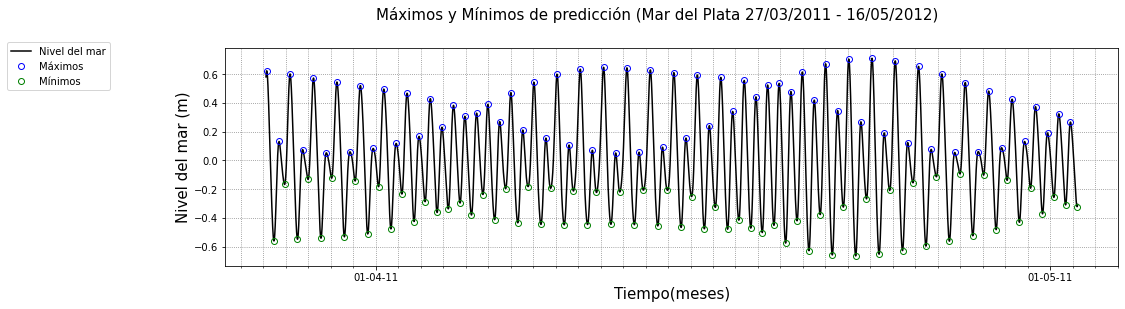

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(16,4))
axs.plot(pred7.fechas.iloc[0:10394],pred7.pred.iloc[0:10394],'k')
axs.plot(altass['fechas'].iloc[0:70],altass['pred'].iloc[0:70],'bo',fillstyle='none')
axs.plot(bajass['fechas'].iloc[0:70],bajass['pred'].iloc[0:70],'go',fillstyle='none')
plt.legend(('Nivel del mar','Máximos','Mínimos'),bbox_to_anchor=[-.25, 1.05], loc='upper left')
axs.xaxis.set_minor_locator(mdates.DayLocator())
axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
fig.suptitle('Máximos y Mínimos de predicción (Mar del Plata 27/03/2011 - 16/05/2012)', x=0.50 ,y=1.025,fontsize=15)
plt.xlabel('Tiempo(meses)', fontsize=15)
plt.ylabel('Nivel del mar (m)', fontsize=15)
axs.grid(which='both',color='grey',linestyle=':')
#plt.legend('Predicción','Máximos','Mínimos',bbox_to_anchor=[-.25, 1.05], loc='upper left')

In [ ]:
posicionMMM=find_peaks(serie.OBS,prominence=.2)[0]
posicionmmm=find_peaks(-(serie.OBS),prominence=.2)[0]
altasss=serie.iloc[posicionMMM]
bajasss=serie.iloc[posicionmmm]
altasss2=altasss.OBS-serie.OBS.mean()
bajasss2=bajasss.OBS-serie.OBS.mean()
PeriodosM=np.diff(posicionMMM)/12
Periodosm=np.diff(posicionmmm)/12
print(np.mean(PeriodosM))
print(np.std(PeriodosM))
print(np.mean(Periodosm))
print(np.std(Periodosm))

11.916267942583731
3.4079321738748694
11.95828331332533
3.5631372589825303


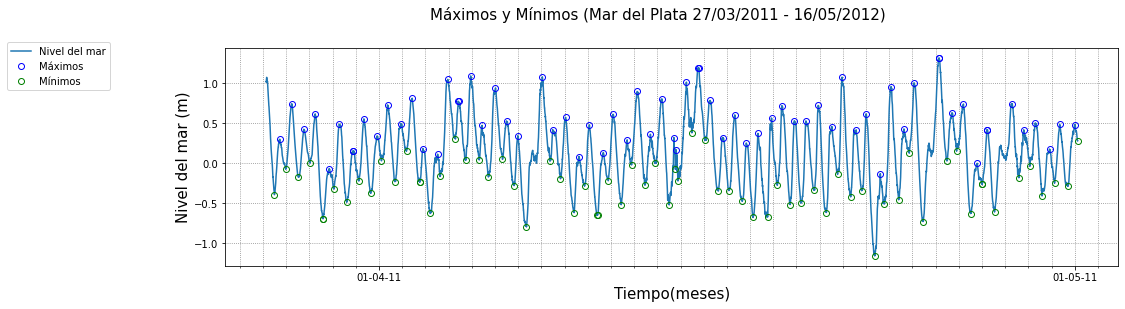

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(16,4))
axs.plot(serie.FECHA.iloc[0:10080],serie.OBS.iloc[0:10080]-serie.OBS.mean())
axs.plot(altasss['FECHA'].iloc[0:70],altasss2.values[0:70],'bo',fillstyle='none')
axs.plot(bajasss['FECHA'].iloc[0:70],bajasss2.values[0:70],'go',fillstyle='none')
plt.legend(('Nivel del mar','Máximos','Mínimos'),bbox_to_anchor=[-.25, 1.05], loc='upper left')
axs.xaxis.set_minor_locator(mdates.DayLocator())
axs.xaxis.set_major_locator(mdates.MonthLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
fig.suptitle('Máximos y Mínimos (Mar del Plata 27/03/2011 - 16/05/2012)', x=0.50 ,y=1.025,fontsize=15)
plt.xlabel('Tiempo(meses)', fontsize=15)
plt.ylabel('Nivel del mar (m)', fontsize=15)
axs.grid(which='both',color='grey',linestyle=':')

In [ ]:
def predc(H,K,fc,vuc):
    fechas_pred1=pd.date_range("12-01-22 00:00:00", periods=len(fc), freq= "H") #mes, dia año (BIEN)*** MODIFIQUE periods=len(fc)
    Qc=len(H)
    ondasc=pd.DataFrame()
    for i in range(Qc):
        #ondas.insert(i,i,(H[i])F.iloc[:,i].values*np.cos(np.deg2rad(sigmas[i]*t1-a1[i])))
        ondasc.insert(i,i,H[i]*fc.iloc[:,i].values*np.cos((vuc.iloc[:,i].values-np.deg2rad(K[i])))) #epoca a radianes nada mas. movi 3 para adelante como intento de corregir huso horario
    sumac=ondasc.sum(axis=1).values
    prediccion2=pd.DataFrame(np.around(sumac,4),index=fechas_pred1,columns=['pred'])
    return prediccion2
    #Error de codigo o argumentos de equilibrio y factores nodales erroneos.

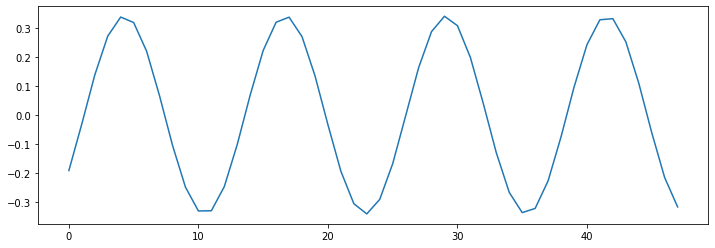

In [ ]:
M2a=H[0]*fc.iloc[:,0].values*np.cos((vuc.iloc[:,0].values-np.deg2rad(K[0])))
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(M2a)

In [ ]:
pred7c=predc(H,K,fc,vuc)
pred7c.index.name='fechas'
pred7c.reset_index(inplace=True)
pred7c

,fechas,pred
0,2022-12-01 00:00:00,-0.5846
1,2022-12-01 01:00:00,-0.4035
2,2022-12-01 02:00:00,-0.1807
3,2022-12-01 03:00:00,0.0043
4,2022-12-01 04:00:00,0.0963
5,2022-12-01 05:00:00,0.0901
6,2022-12-01 06:00:00,0.0218
7,2022-12-01 07:00:00,-0.0623
8,2022-12-01 08:00:00,-0.1323
9,2022-12-01 09:00:00,-0.1765


In [ ]:
posicionM=find_peaks(pred7c.pred)[0]
posicionm=find_peaks(-pred7c.pred)[0]
altas=pred7c.iloc[posicionM]
bajas=pred7c.iloc[posicionm]
#altas.index.name='fechas'
#altas.reset_index(inplace=True)
#bajas.index.name='fechas'
#bajas.reset_index(inplace=True)->NO NECESARIO, "FECHAS" definido.
print(altas)
print(bajas)

                fechas    pred
4  2022-12-01 04:00:00  0.0963
16 2022-12-01 16:00:00  0.7298
29 2022-12-02 05:00:00  0.1253
41 2022-12-02 17:00:00  0.6548
                fechas    pred
10 2022-12-01 10:00:00 -0.1837
24 2022-12-02 00:00:00 -0.6334
35 2022-12-02 11:00:00 -0.1862


In [ ]:
SHN=pd.DataFrame.from_dict(
    {   'fechas': ['12-01-22 04:28:00', '12-01-22 09:37:00', '12-01-22 15:57:00', '12-02-22 00:05:00'], #01:28:00 06:37:00 12:57:00 21:05:00
        'Altura': [.09, -.17,.71, -.63],
    }
)
SHN['fechas'] = pd.to_datetime(SHN['fechas'])
#fechas_pred1=pd.date_range("01-12-22 00:00:00", periods=len(fc), freq= "H")
#prediccion=pd.DataFrame(np.around(suma,4),index=fechas_pred,columns=['pred'])
#01:28 	1,00
	#06:37 	0,74
	#12:57 	1,62
	#21:05 	0,28

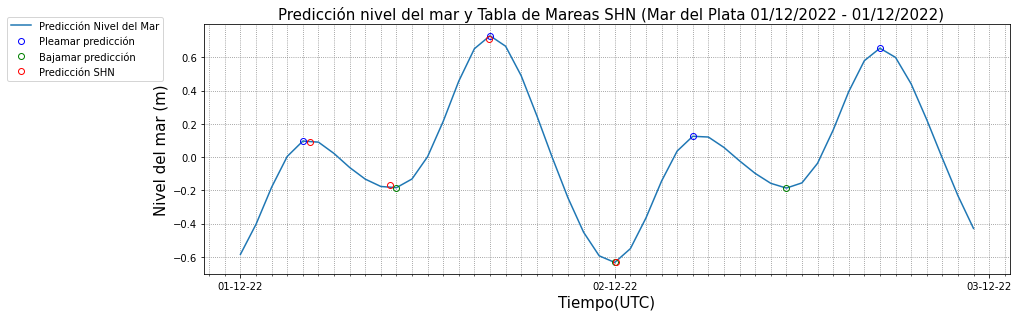

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(pred7c.fechas,pred7c.pred)
plt.tight_layout()
axs.plot(altas['fechas'],altas['pred'],'bo',fillstyle='none')
axs.plot(bajas['fechas'],bajas['pred'],'go',fillstyle='none')
axs.plot(SHN['fechas'],SHN['Altura'],'ro',fillstyle='none')
axs.xaxis.set_major_locator(mdates.DayLocator())
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
axs.xaxis.set_minor_locator(mdates.HourLocator())
fig.suptitle('Predicción nivel del mar y Tabla de Mareas SHN (Mar del Plata 01/12/2022 - 01/12/2022)', x=0.52 ,y=1.025,fontsize=15)
plt.legend(('Predicción Nivel del Mar','Pleamar predicción','Bajamar predicción','Predicción SHN'),bbox_to_anchor=[-.25, 1.05], loc='upper left')
plt.xlabel('Tiempo(UTC)', fontsize=15)
plt.ylabel('Nivel del mar (m)', fontsize=15)
axs.grid(which='both',color='grey',linestyle=':')

In [ ]:
print(SHN)
print(altas)
print(bajas)

               fechas  Altura
0 2022-12-01 04:28:00    0.09
1 2022-12-01 09:37:00   -0.17
2 2022-12-01 15:57:00    0.71
3 2022-12-02 00:05:00   -0.63
                fechas    pred
4  2022-12-01 04:00:00  0.0963
16 2022-12-01 16:00:00  0.7298
29 2022-12-02 05:00:00  0.1253
41 2022-12-02 17:00:00  0.6548
                fechas    pred
10 2022-12-01 10:00:00 -0.1837
24 2022-12-02 00:00:00 -0.6334
35 2022-12-02 11:00:00 -0.1862


In [ ]:
#01:28 	1,00
	#06:37 	0,74
	#12:57 	1,62
	#21:05 	0,28
serie

,FECHA,OBS
0,2011-03-27 03:00:00,1.969
1,2011-03-27 03:05:00,1.967
2,2011-03-27 03:10:00,1.968
3,2011-03-27 03:15:00,1.968
4,2011-03-27 03:20:00,1.981
...,...,...
119798,2012-05-16 02:10:00,0.392
119799,2012-05-16 02:15:00,0.393
119800,2012-05-16 02:20:00,0.398
119801,2012-05-16 02:25:00,0.402


In [ ]:
s3=serie.OBS.values
dt3=1/12
def AnArv(s3,sigmas,dt3):
  Qv=8
  Tv=len(s3)
  sv=s3[0:(Tv-1+Tv%2)]
  Tv=len(sv)
  #t1=np.linspace(-(T1//2),T1//2,len(s1))
  tv=np.linspace(0,len(sv)*dt3,len(sv))
  eleAv=[]
  eleBv=[]
  for i in range(Qv):
    eleAv.append(np.cos(np.radians(sigmas[i]*tv)))
    eleBv.append(np.sin(np.radians(sigmas[i]*tv)))
  eleAv=np.array(eleAv)
  eleBv=np.array(eleBv)
  ELE1=np.concatenate((eleAv.T,eleBv.T),axis=1)
  vemosELE1=np.linalg.lstsq(ELE1,sv,rcond=None)
  R1=np.around(np.sqrt(vemosELE1[0][0:Qv]**2+vemosELE1[0][Qv::]**2),4)
  a1=np.around(np.arctan2(vemosELE1[0][Qv::],vemosELE1[0][0:Qv]),4)
  a1=a1*180/np.pi
  a1[a1<0]=a1[a1<0]+360
  a1=np.around(a1,4)
  return(R1,a1)

In [ ]:
#Predicción vieja
R1,a1=AnArv(s3,sigmas,dt3)
def pred3(R1,a1,tv,sigmas):
    fechas_pred=pd.date_range("03-27-11 00:00:00", periods=len(s3), freq= "5min")
    Qv=len(R1)
    ondas=pd.DataFrame()
    for i in range(Qv):
        ondas.insert(i,i,(R1[i])*np.cos(np.deg2rad(sigmas[i]*tv-a1[i])))
    suma=ondas.sum(axis=1).values
    prediccion3=pd.DataFrame(np.around(suma,4),index=fechas_pred,columns=['pred'])
    return prediccion3

In [ ]:
ts=np.linspace(0,len(s3)*dt3,len(s3))
pred7o=pred3(R1,a1,ts,sigmas)
pred7o.index.name='fechas'
pred7o.reset_index(inplace=True)
pred7o

,fechas,pred
0,2011-03-27 00:00:00,1.4868
1,2011-03-27 00:05:00,1.4956
2,2011-03-27 00:10:00,1.5038
3,2011-03-27 00:15:00,1.5113
4,2011-03-27 00:20:00,1.5182
...,...,...
119798,2012-05-15 23:10:00,0.8689
119799,2012-05-15 23:15:00,0.8788
119800,2012-05-15 23:20:00,0.8889
119801,2012-05-15 23:25:00,0.8995


In [ ]:
#Predicción sin época cumpleaños.
def pred4(R1,a1,tv,sigmas):
    fechas_pred2=pd.date_range("03-27-11 00:00:00", periods=1229185, freq= "5min") #repaso: mes-dia-año
    Qv=len(R1)
    ondas=pd.DataFrame()
    for i in range(Qv):
        ondas.insert(i,i,(R1[i])*np.cos(np.deg2rad(sigmas[i]*tv-a1[i])))
    suma=ondas.sum(axis=1).values
    prediccion4=pd.DataFrame(np.around(suma,4),index=fechas_pred2,columns=['pred'])
    return prediccion4

In [ ]:
ts2=np.linspace(0,1229185*dt3,1229185)
pred7o2=pred4(R1,a1,ts2,sigmas)
pred7o2.index.name='fechas'
pred7o2.reset_index(inplace=True)
pred7o2

,fechas,pred
0,2011-03-27 00:00:00,1.4868
1,2011-03-27 00:05:00,1.4956
2,2011-03-27 00:10:00,1.5038
3,2011-03-27 00:15:00,1.5113
4,2011-03-27 00:20:00,1.5182
...,...,...
1229180,2022-12-01 23:40:00,0.8713
1229181,2022-12-01 23:45:00,0.8878
1229182,2022-12-01 23:50:00,0.9041
1229183,2022-12-01 23:55:00,0.9202


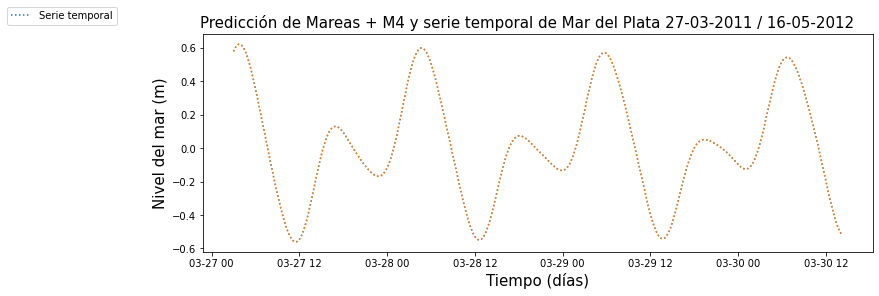

In [ ]:
fig,axs=plt.subplots(1,1,figsize=(12,4))
#axs.plot(seriegonz.FECHA,seriegonz.OBS)
axs.plot(pred7.fechas.iloc[0:1000],pred7.pred.iloc[0:1000],':')
#ax.plot(altas['fechas'].iloc[0:7],altas['fechas'].iloc[0:7],'bo',fillstyle='none')
#ax.plot(bajas['fechas'].iloc[0:7],bajas['OBS'].iloc[0:7],'go',fillstyle='none')
fig.suptitle('Predicción de Mareas + M4 y serie temporal de Mar del Plata 27-03-2011 / 16-05-2012', x=.5,y=0.95,fontsize=15)
plt.legend(("Serie temporal", "Predición de mareas"),bbox_to_anchor=[-.3, 1.15], loc='upper left')
plt.ylabel('Nivel del mar (m)', fontsize=15)
plt.xlabel('Tiempo (días)',fontsize=15)
axs.plot(pred7.fechas.iloc[0:1000],pred7.pred.iloc[0:1000],':')

Text(0.5, 0, 'Tiempo (meses)')

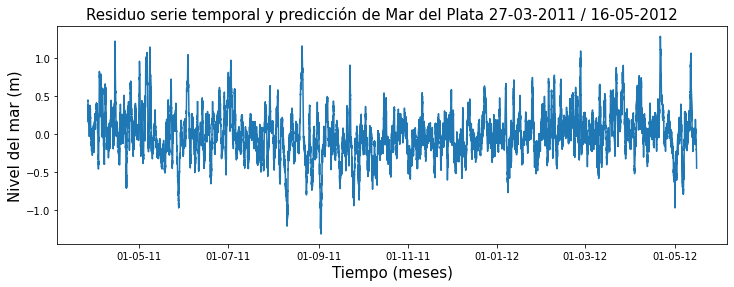

In [ ]:
residuo=serie1-pred7.pred
residuo

fig,axs=plt.subplots(1,1,figsize=(12,4))
fig.suptitle('Residuo serie temporal y predicción de Mar del Plata 27-03-2011 / 16-05-2012', x=.5,y=0.95,fontsize=15)
axs.plot(serie.FECHA,residuo.values)
axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
plt.ylabel('Nivel del mar (m)', fontsize=15)
plt.xlabel('Tiempo (meses)',fontsize=15)

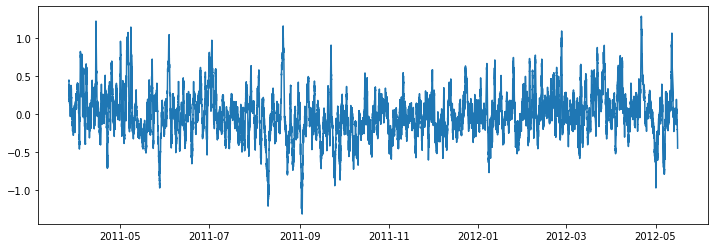

In [ ]:
residuo2=serie1-pred7o.pred
residuo2
fig,axs=plt.subplots(1,1,figsize=(12,4))
axs.plot(serie.FECHA,residuo.values)

In [ ]:
H

array([0.3505, 0.0543, 0.1007, 0.0193, 0.1648, 0.179 , 0.0469, 0.0368])

In [ ]:
np.deg2rad(K)

array([5.34018566, 0.2728002 , 4.63038469, 0.49450065, 2.97380019,
       1.34110053, 2.85079986, 3.18148564])

In [ ]:
F

,# ['M2','S2','N2','K2','K1','O1','P1','M4']
0,1.001609,1.0,1.001609,1.003982,1.010368,1.016236,1.0,1.003221
1,1.001609,1.0,1.001609,1.003981,1.010367,1.016235,1.0,1.003221
2,1.001609,1.0,1.001609,1.003980,1.010367,1.016235,1.0,1.003221
3,1.001610,1.0,1.001610,1.003979,1.010366,1.016234,1.0,1.003222
4,1.001610,1.0,1.001610,1.003978,1.010366,1.016233,1.0,1.003222
...,...,...,...,...,...,...,...,...
119798,1.015544,1.0,1.015544,0.898565,0.965221,0.943159,1.0,1.031330
119799,1.015544,1.0,1.015544,0.898564,0.965220,0.943158,1.0,1.031331
119800,1.015545,1.0,1.015545,0.898564,0.965220,0.943158,1.0,1.031331
119801,1.015545,1.0,1.015545,0.898563,0.965219,0.943157,1.0,1.031331


In [ ]:

print (H)
print(K)

[0.3505 0.0543 0.1007 0.0193 0.1648 0.179  0.0469 0.0368]
[305.9701  15.6303 265.3015  28.3328 170.3862  76.8394 163.3388 182.2857]
